# Load files

In [0]:
!pip install -q -U PyDrive # to get access to files

# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1joDmxc9dbVHB0XuJrLtY5nlOX339dd5R'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('Final_data.zip')
!unzip -q Final_data.zip
!ls Final_data

Final_data


In [0]:
import numpy as np              #numpy library is used to work with multidimensional array.
import pandas as pd             #panda used for data manipulation and analysis.                
import os                       #os library is used for loading file to use in the program
import json                     #json library parses json into a string or dict, and convert string or dict to json file.
from pathlib import Path        #support path
import matplotlib.pyplot as plt #support ploting a figure
from matplotlib import colors   #colors support converting number or argument into colors
from tqdm.notebook import tqdm
from torch import FloatTensor, LongTensor
import torch
from torch.nn import CrossEntropyLoss
from torch.autograd import Variable
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F
from import_plot import *

is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

def inp2img(inp):
    inp = np.array(inp)
    img = np.full((10, inp.shape[0], inp.shape[1]), 0, dtype=np.uint8)
    for i in range(10):
        img[i] = (inp==i)
    return img


In [0]:
dimension_explained('train')
dimension_explained('eval')
dimension_explained('test')

------------ train  shapes ------------
t1 all inputs are equal:  210 of which: 
t1_1 also output equal:  134
t1_2 output smaller but fixed:  43
t1_3 output bigger but fixed:  19
t1_4 output size depends on input 14
t2 input different:  190 of which: 
t2_1 output equal to input:  128
t2_2 output smaller :  50
t2_3 output bigger :  12
------------ eval  shapes ------------
t1 all inputs are equal:  157 of which: 
t1_1 also output equal:  92
t1_2 output smaller but fixed:  32
t1_3 output bigger but fixed:  20
t1_4 output size depends on input 13
t2 input different:  243 of which: 
t2_1 output equal to input:  178
t2_2 output smaller :  51
t2_3 output bigger :  14
------------ test  shapes ------------
t1 all inputs are equal:  41 of which: 
t1_1 also output equal:  23
t1_2 output smaller but fixed:  8
t1_3 output bigger but fixed:  7
t1_4 output size depends on input 3
t2 input different:  59 of which: 
t2_1 output equal to input:  42
t2_2 output smaller :  15
t2_3 output bigger :  2


# All 7 task

In [0]:
# TASK 1 - Same dimension: Mirror right and down
def gener_one():
    skeleton=np.random.randint(2,size=(3,4))
    color=np.random.randint(1, 10)
    inp=np.where(skeleton==0, 0, color)
    flip_right=np.concatenate((inp,np.flip(inp, axis=1)), axis=1)
    out=np.concatenate((flip_right,np.flip(flip_right, axis=0)), axis=0)
    return(inp, out)

In [0]:
# TASK 2 - Same dimension: Concatenate and flip central row
def gener_two():
    inp=np.random.randint(1,10,size=(2,2))
    flip=np.flip(inp, axis=1)
    conc1=np.concatenate((inp, inp, inp), axis=1)
    conc2=np.concatenate((flip, flip, flip), axis=1)
    out=np.concatenate((conc1, conc2, conc1), axis=0)
    return(inp, out)

In [0]:
# TASK 3 - Same dimension: Pattern filler
def gener_three():
    a = np.random.randint(2, 10, (8, 8))
    a = np.where(a==4, 1, a)
    m = np.tril(a) + np.tril(a, -1).T
    m = np.concatenate((m, np.flip(m, axis=0)), axis=0)
    out= np.concatenate((m, np.flip(m)), axis=1)
    inp = out.copy()

    p1=np.random.randint(1, 13)
    p2=np.random.randint(p1+2, p1+5)
    p3=np.random.randint(1, 13)
    p4=np.random.randint(p3+2, p3+5)

    inp[p1:p2, p3:p4]=4

    p1=np.random.randint(1, 13)
    p2=np.random.randint(p1+2, p1+5)
    p3=np.random.randint(1, 13)
    p4=np.random.randint(p3+2, p3+5)

    inp[p1:p2, p3:p4]=4 
    
    return(inp, out)

In [0]:
# TASK 4 - Different dimension: Denoise
def gener_four():
    dim1=np.random.randint(10,15)
    dim2=np.random.randint(13,18)
    out=np.zeros((dim1,dim2))
    col=np.random.choice([2,3,5])
    colno=np.random.choice([1,4,8])
    nsquare=np.random.randint(3,5)
    nnoise=np.random.randint(10,20)
    for sq in range(0,nsquare):
        p1=np.random.randint(0, dim1-1)
        p2=np.random.randint(p1+2, p1+8)
        p3=np.random.randint(0, dim2-1)
        p4=np.random.randint(p3+2, p3+8)

        out[p1:p2, p3:p4]=col

    inp=out.copy()

    for noise in range(0,nnoise):
        p1=np.random.randint(0, dim1)
        p2=np.random.randint(0, dim2)

        inp[p1,p2]=colno
    return(inp, out)

In [0]:
# TASK 5 - Different dimension: 2 squares
def gener_five():
    dim1=np.random.randint(5,11)
    dim2=np.random.randint(5,11)
    out=np.zeros((dim1,dim2))
    inp=out.copy()
    col=np.random.randint(1,10)
    col2=np.random.randint(1,10)
    nsquare=np.random.randint(1,3)
    
    flippoints=np.random.randint(1,3)
    
    while col2==col:
        col2=np.random.randint(1,10)

    if nsquare==1:
        p1=np.random.randint(0, dim1-2)
        p2=np.random.randint(p1+2,dim1)
        p3=np.random.randint(0, dim2-2)
        p4=np.random.randint(p3+2,dim2)

        out[p1:p2+1, p3:p4+1]=col
        inp[p1, p3]=col
        inp[p2, p4]=col
    if nsquare==2:
        if dim1>dim2:
            p1= np.random.randint(0, dim1-3)
            p2= np.random.randint(p1+1, dim1-2)
            p11= np.random.randint(p2+1, dim1-1)
            p22= np.random.randint(p11+1, dim1)
            p3= np.random.randint(0, dim2-3)
            p4= np.random.randint(p3+1, dim2)
            p33= np.random.randint(0, dim2-3)
            p44= np.random.randint(p33+1, dim2)

            out[p1:p2+1, p3:p4+1]=col            
            out[p11:p22+1, p33:p44+1]=col2
            
            if flippoints==1:
                inp[p1, p3]=col
                inp[p2, p4]=col            
                inp[p22, p33]=col2
                inp[p11, p44]=col2
            else:
                inp[p2, p3]=col
                inp[p1, p4]=col            
                inp[p11, p33]=col2
                inp[p22, p44]=col2
                
        else:
            p1= np.random.randint(0, dim1-3)
            p2= np.random.randint(p1+1, dim1)
            p11= np.random.randint(0, dim1-3)
            p22= np.random.randint(p11+1, dim1)
            p3= np.random.randint(0, dim2-3)
            p4= np.random.randint(p3+1, dim2-2)
            p33= np.random.randint(p4+1, dim2-1)
            p44= np.random.randint(p33+1, dim2)

            out[p1:p2+1, p3:p4+1]=col            
            out[p11:p22+1, p33:p44+1]=col2
            
            if flippoints==1:
                inp[p1, p3]=col
                inp[p2, p4]=col            
                inp[p22, p33]=col2
                inp[p11, p44]=col2
            else:
                inp[p2, p3]=col
                inp[p1, p4]=col            
                inp[p11, p33]=col2
                inp[p22, p44]=col2
    return(inp, out)

In [0]:
# TASK 6 - Different dimension: smallest squares
def gener_six():
    dim1=np.random.randint(8,21)
    dim2=np.random.randint(8,21)
    inp=np.zeros((dim1,dim2))
    nsquare=np.random.randint(2,6)
    colors=np.random.choice(range(1,10),5, replace=False)
    sqs=[]
    for i in range(0, nsquare):
        p1=np.random.randint(1, dim1-3)
        p2=np.random.randint(p1+1,dim1-1)
        p3=np.random.randint(1, dim2-3)
        p4=np.random.randint(p3+1,dim2-1)
        sqs.append([((p2-p1)*(p4-p3)), p1,p2,p3,p4, colors[i]])
        
    sortt=sorted(sqs, reverse=True)
    for sq in sortt:
        _,p1,p2,p3,p4,col=sq
        inp[p1:p2+1, p3:p4+1]=col
    _,p1,p2,p3,p4,col=sortt[-1]
    
    out=np.ones((p2-p1,p4-p3))*col
    
    
    return(inp, out)

In [0]:
# TASK 7 - Different dimension: inverter
def gener_seven():
    dim1=np.random.randint(18,26)
    dim2=np.random.randint(18,26)
    colors=np.random.choice(range(1,10),2, replace=False)
    inp=np.zeros((dim1,dim2))
    
    nnoise=np.random.randint(15,50)
    for noise in range(0,nnoise):
        p1=np.random.randint(0, dim1)
        p2=np.random.randint(0, dim2)

        inp[p1,p2]=colors[0]
        
    
    
    skel=np.random.randint(2,size=(3,3))
    out=skel*colors[0]
    topaste=np.kron(skel, np.ones((4,4)))*colors[1]
    
    p1=np.random.randint(0, dim1-12)
    p2=np.random.randint(0,dim2-12)
    
    inp[p1:p1+12, p2:p2+12]=topaste
    
    return(inp, out)

# Useful functions:

1.   evaluate (to train model)
2.   plot_metrics (to plot resulting metrics)
3.   pad_crop (to pad and then crop the model)




In [0]:
class TaskSolver:        

    def train(self, task, model_name, n_epoch=30, verbose=True):
        """basic pytorch train loop"""
        loss_train = []
        loss_val = []
        accuracy_val = []
        accuracy_train = []
        accuracy_val_pix = []
        accuracy_train_pix = []

        sh1_big = 0
        sh2_big = 0
        for i in range(len(task['train'])):
          sh1 = task['train'][i]['input'].shape[0]
          sh2 = task['train'][i]['input'].shape[1]
          if sh1 > sh1_big:
            sh1_big = sh1
          if sh2 > sh2_big:
            sh2_big = sh2     
        for i in range(len(task['test'])):
          sh1 = task['test'][i]['input'].shape[0]
          sh2 = task['test'][i]['input'].shape[1]
          if sh1 > sh1_big:
            sh1_big = sh1
          if sh2 > sh2_big:
            sh2_big = sh2  

        self.net = model_name(task['train'], sh1_big, sh2_big) # MODEL
        criterion = CrossEntropyLoss()
        optimizer = Adam(self.net.parameters(), lr = 0.1)
        
        for epoch in tqdm(range(n_epoch)):
        
          self.net.train()
          loss_iter = 0
          for sample in task['train']:
              img = FloatTensor(inp2img(sample['input'])).to(device)
              labels = LongTensor(sample['output']).unsqueeze(dim=0).to(device)
              optimizer.zero_grad()                
              outputs = self.net(img)
              outputs = outputs
              loss = criterion(outputs, labels)
              loss.backward()
              optimizer.step()  
                  
          self.net.eval()
          with torch.no_grad():

            correct_val = 0
            correct_val_pix = 0
            total_val = 0
            loss_iter_val = 0
            predictions = []
            wrong_pred = []
            n_pixels_val = 0
            for sample in task['test']:

              img = FloatTensor(inp2img(sample['input'])).to(device)
              labels = LongTensor(sample['output']).unsqueeze(dim=0).to(device)
              outputs = self.net(img)
              _, pred = torch.max(outputs.data, 1)
              predictions.append((img, pred))  
              n_pixels_val += pred.shape[1]*pred.shape[2]

              total_val += labels.size(0)
              flag =  (torch.all(torch.eq(pred, labels))).sum().item() 
              correct_val += flag
              if flag == 0:
                wrong_pred.append((img, pred))
              correct_val_pix += (torch.eq(pred, labels)).sum().item()            
              loss = criterion(outputs, labels)
              loss_iter_val += loss.item()

            correct_train = 0
            correct_train_pix = 0 
            total_train = 0
            loss_iter_train = 0
            n_pixels_train = 0
            for sample in task['train']:

              img = FloatTensor(inp2img(sample['input'])).to(device)
              labels = LongTensor(sample['output']).unsqueeze(dim=0).to(device)
              outputs = self.net(img)
              _, pred = torch.max(outputs.data, 1)
              n_pixels_train += pred.shape[1]*pred.shape[2]

              total_train += labels.size(0)
              correct_train += (torch.all(torch.eq(pred, labels))).sum().item()
              correct_train_pix += (torch.eq(pred, labels)).sum().item()
              loss = criterion(outputs, labels)
              loss_iter_train += loss.item()
              
          loss_train.append(loss_iter_train/len(task['train']))
          loss_val.append(loss_iter_val/len(task['test']))

          val_accuracy = 100 * correct_val / total_val
          val_accuracy_pix = 100 * correct_val_pix/(n_pixels_val)
          accuracy_val.append(val_accuracy)
          accuracy_val_pix.append(val_accuracy_pix)

          train_accuracy = 100 * correct_train / total_train
          train_accuracy_pix = 100 * correct_train_pix/(n_pixels_train)
          accuracy_train.append(train_accuracy)
          accuracy_train_pix.append(train_accuracy_pix)

          if verbose:
            print('\nEpoch: ['+str(epoch+1)+'/'+str(n_epoch)+']')
            print('Train loss is: {}'.format(loss_train[-1]))
            print('Validation loss is: {}'.format(loss_val[-1]))
            print('Train accuracy is: {} %'.format(accuracy_train[-1]))
            print('Train accuracy for pixels is: {} %'.format(accuracy_train_pix[-1]))
            print('Validation accuracy is: {} %'.format(accuracy_val[-1]))
            print('Validation accuracy for pixels is: {} %'.format(accuracy_val_pix[-1]))

        metrics = {'loss_train': loss_train, 'loss_val': loss_val, 'accuracy_train':accuracy_train, 
                   'accuracy_train_pix': accuracy_train_pix, 'accuracy_val':accuracy_val, 
                   'accuracy_val_pix': accuracy_val_pix}
        final_pred = predictions
        return metrics, final_pred, wrong_pred

def evaluate_metrics(task, model_name, n_epoch, verbose):
  ts = TaskSolver()
  return ts.train(task, model_name, n_epoch=n_epoch, verbose=verbose)

def plot_metrics(train_result):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(35,7), dpi=50)

  ax1.plot(train_result['loss_train'], c='r', label = 'Train loss')
  ax1.plot(train_result['loss_val'], c='g', label = 'Val. loss')
  ax1.legend(prop={'size': 18}, loc='upper right')
  ax1.set_xlabel('Loss', fontsize=22)
  ax1.tick_params(labelsize=18)

  ax2.plot(train_result['accuracy_train'], c='r', label = 'Train accuracy')
  ax2.plot(train_result['accuracy_val'], c='g', label = 'Val. accuracy')
  ax2.legend(prop={'size': 18}, loc='lower right')
  ax2.set_xlabel('Accuracy', fontsize=22)
  ax2.tick_params(labelsize=18)

  ax3.plot(train_result['accuracy_train_pix'], c='r', label = 'Train accuracy on pixels')
  ax3.plot(train_result['accuracy_val_pix'], c='g', label = 'Val. accuracy on pixels')
  ax3.legend(prop={'size': 18}, loc='lower right')
  ax3.set_xlabel('Accuracy for pixels', fontsize=22)
  ax3.tick_params(labelsize=18)

  plt.show()

  def inverse_10_channels(res):
    a = np.array(res)
    img = np.full((a.shape[1], a.shape[2]), 0, dtype=np.uint8)
    for i in range(10):
      img = np.add(img, np.where(a[i]>0, i, a[i]))
    return img


In [0]:
def pad_crop(x, desired_w, desired_h, current_w, current_h, goal):
        
    diff_w = np.abs(desired_w-current_w)
    if diff_w % 2 == 0:
      if goal == 'pad':
        x = F.pad(x, (0, 0, int(diff_w/2), int(diff_w/2)), mode='constant', value=0)
      elif goal == 'crop':
        if -int(diff_w/2) == 0:
          x = x[:, :, int(diff_w/2):, :]
        else:
          x = x[:, :, int(diff_w/2):-int(diff_w/2), :]
      else:
        pass
    else:
      if goal == 'pad':
        x = F.pad(x, (0, 0, int(diff_w/2)+1, int(diff_w/2)), mode='constant', value=0)
      elif goal == 'crop':
        if -int(diff_w/2) == 0:
          x = x[:, :, int(diff_w/2)+1:, :]
        else:
          x = x[:, :, int(diff_w/2)+1:-int(diff_w/2), :]
      else:
        pass

    diff_h = np.abs(desired_h-current_h)
    if diff_h % 2 == 0:
      if goal == 'pad':
        x = F.pad(x, (int(diff_h/2), int(diff_h/2), 0, 0), mode='constant', value=0)
      elif goal == 'crop':
        if (-int(diff_h/2)) == 0:
          x = x[:, :, :, int(diff_h/2):]
        else:
          x = x[:, :, :, int(diff_h/2):-int(diff_h/2)]
      else:
        pass
    else:
      if goal == 'pad':
        x = F.pad(x, (int(diff_h/2)+1, int(diff_h/2), 0, 0), mode='constant', value=0)
      elif goal == 'crop':
        if (-int(diff_h/2)) == 0:
          x = x[:, :, :, int(diff_h/2)+1:] 
        else:
          x = x[:, :, :, int(diff_h/2)+1:-int(diff_h/2)]  
      else:
        pass

    return x

# Try tasks one by one

## Task 1:


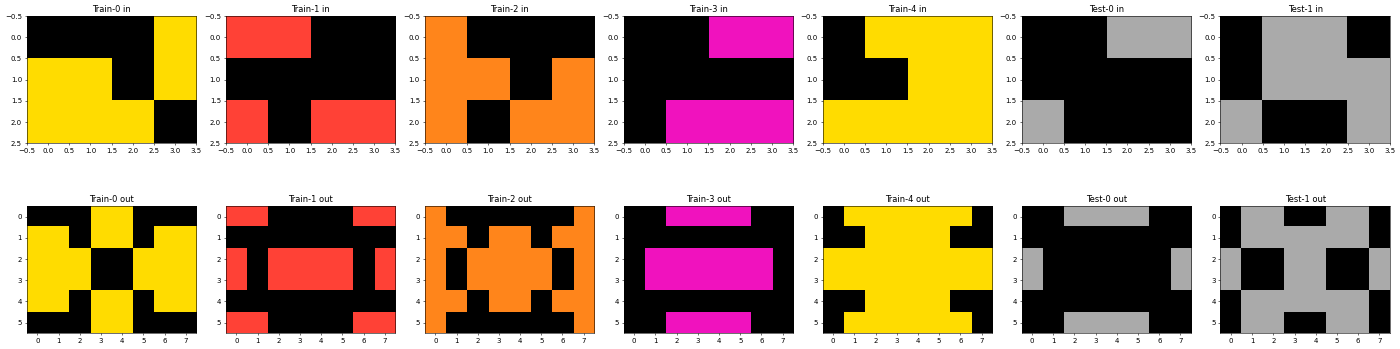

In [0]:
def task_builder(n_train=1000, n_test=250):
    task={'train':[], 'test':[]}
    for i in range(0,n_train):
        inp, out = gener_one()
        task['train'].append({'input':inp, 'output':out})
    for i in range(0,n_test):
        inp, out = gener_one()
        task['test'].append({'input':inp, 'output':out})
    return task

task=task_builder(5, 2)
plot_task(task)

### Fully connected NN

In [0]:
class FullyConNN(nn.Module):
  
  def __init__(self, task_train, w, h):
    super(FullyConNN, self).__init__()

    self.inp_dim = np.array(np.array(task_train[0]['input']).shape)
    self.out_dim = np.array(np.array(task_train[0]['output']).shape)
    self.linear = nn.Linear(self.inp_dim[0]*self.inp_dim[1]*10, self.out_dim[0]*self.out_dim[1]*10)

  def forward(self, x):
    x = x.view(-1) # Flatten
    x = self.linear(x) # Dense
    x = torch.reshape(x, (1, 10, self.out_dim[0], self.out_dim[1])) # Reshape
    return x

In [0]:
# Training
fcNN_result_T1, fcNN__predictions_T1, fcNN_wrong_pred_T1 = evaluate_metrics(task_builder(10000, 100), FullyConNN, 
                                                                            n_epoch=10, verbose=True)


Epoch: [1/10]
Train loss is: 0.049443772744036815
Validation loss is: 0.03980485550226945
Train accuracy is: 76.67 %
Train accuracy for pixels is: 99.375625 %
Validation accuracy is: 72.0 %
Validation accuracy for pixels is: 99.39583333333333 %

Epoch: [2/10]
Train loss is: 0.003408031092873665
Validation loss is: 0.00025848372301165765
Train accuracy is: 97.52 %
Train accuracy for pixels is: 99.93895833333333 %
Validation accuracy is: 100.0 %
Validation accuracy for pixels is: 100.0 %

Epoch: [3/10]
Train loss is: 0.0003223033730214319
Validation loss is: 0.0014931399628154872
Train accuracy is: 99.52 %
Train accuracy for pixels is: 99.99 %
Validation accuracy is: 99.0 %
Validation accuracy for pixels is: 99.97916666666667 %

Epoch: [4/10]
Train loss is: 2.9817719992761023e-07
Validation loss is: 5.262007762551167e-07
Train accuracy is: 100.0 %
Train accuracy for pixels is: 100.0 %
Validation accuracy is: 100.0 %
Validation accuracy for pixels is: 100.0 %

Epoch: [5/10]
Train loss is

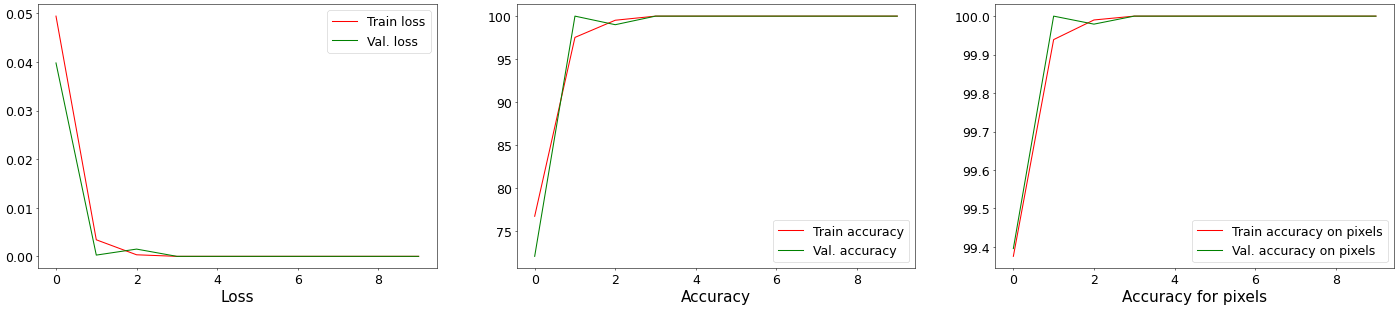

In [0]:
plot_metrics(fcNN_result_T1)

### LSTM 

In [0]:
class LSTM(nn.Module):
  def __init__(self, task_train, w, h):
    super(LSTM, self).__init__()

    self.inp_dim = np.array(np.array(task_train[0]['input']).shape)
    self.out_dim = np.array(np.array(task_train[0]['output']).shape)
    self.lstm = nn.LSTM(self.inp_dim[0]*self.inp_dim[1], self.out_dim[0]*self.out_dim[1], dropout=0, batch_first=True)
    #self.linear = nn.Linear(self.out_dim[0]*self.out_dim[1], self.out_dim[0]*self.out_dim[1])    

  def forward(self, x): 
    sh1, sh2, sh3 = x.shape[0], x.shape[1], x.shape[2]
    x = x.view(sh1, -1).unsqueeze(0)
    x, _ = self.lstm(x)
    #x = self.linear(x)
    x = torch.reshape(x, (1, 10, self.out_dim[0], self.out_dim[1])) # Reshape
    return x

In [0]:
# Training of LSTM+fcl
LSTM_result_T1, LSTM__predictions_T1, LSTM_wrong_pred_T1 = evaluate_metrics(task_builder(10000, 100), LSTM, 
                                                                            n_epoch = 10, verbose = True)


Epoch: [1/10]
Train loss is: 0.009606958991584006
Validation loss is: 0.014013873556016434
Train accuracy is: 96.74 %
Train accuracy for pixels is: 99.7275 %
Validation accuracy is: 94.0 %
Validation accuracy for pixels is: 99.5 %

Epoch: [2/10]
Train loss is: 0.008589557647351084
Validation loss is: 0.002481752500671779
Train accuracy is: 96.73 %
Train accuracy for pixels is: 99.83333333333333 %
Validation accuracy is: 96.0 %
Validation accuracy for pixels is: 99.89583333333333 %

Epoch: [3/10]
Train loss is: 0.00041382579321869894
Validation loss is: 4.033889646387013e-06
Train accuracy is: 99.48 %
Train accuracy for pixels is: 99.98625 %
Validation accuracy is: 100.0 %
Validation accuracy for pixels is: 100.0 %

Epoch: [4/10]
Train loss is: 0.0020848243423406787
Validation loss is: 0.0005012414980086866
Train accuracy is: 99.17 %
Train accuracy for pixels is: 99.97083333333333 %
Validation accuracy is: 99.0 %
Validation accuracy for pixels is: 99.95833333333333 %

Epoch: [5/10]
Tra

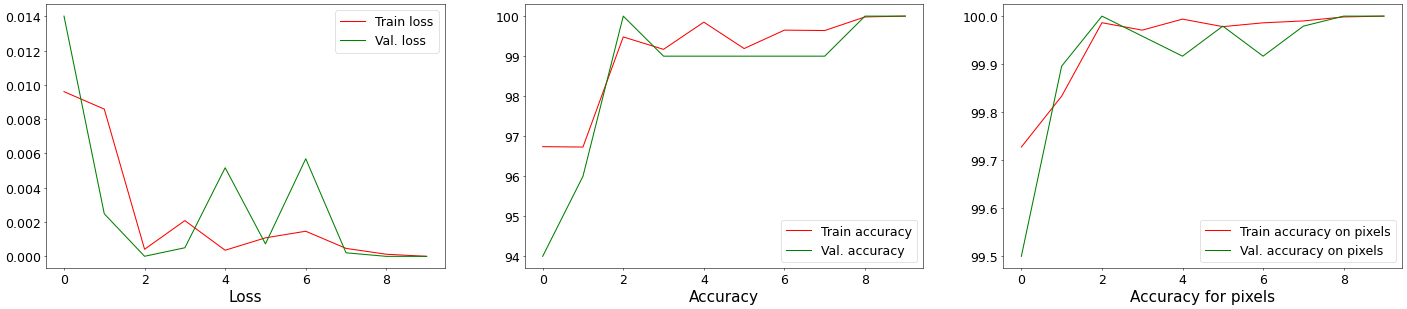

In [0]:
plot_metrics(LSTM_result_T1) # LSTM+fcl

In [0]:
# Training of LSTM alone
LSTM_result_T1, LSTM__predictions_T1, LSTM_wrong_pred_T1 = evaluate_metrics(task_builder(10000, 100), LSTM, 
                                                                            n_epoch = 10, verbose = True)


Epoch: [1/10]
Train loss is: 1.4163762134671212
Validation loss is: 1.4182110285758973
Train accuracy is: 3.73 %
Train accuracy for pixels is: 89.38895833333333 %
Validation accuracy is: 2.0 %
Validation accuracy for pixels is: 89.20833333333333 %

Epoch: [2/10]
Train loss is: 1.3554937895655632
Validation loss is: 1.3540194404125214
Train accuracy is: 0.7 %
Train accuracy for pixels is: 93.35041666666666 %
Validation accuracy is: 1.0 %
Validation accuracy for pixels is: 93.625 %

Epoch: [3/10]
Train loss is: 1.366520606327057
Validation loss is: 1.3639681804180146
Train accuracy is: 0.42 %
Train accuracy for pixels is: 93.27416666666667 %
Validation accuracy is: 1.0 %
Validation accuracy for pixels is: 93.5 %

Epoch: [4/10]
Train loss is: 1.3707844683408736
Validation loss is: 1.370719004869461
Train accuracy is: 0.24 %
Train accuracy for pixels is: 92.68104166666667 %
Validation accuracy is: 0.0 %
Validation accuracy for pixels is: 92.39583333333333 %

Epoch: [5/10]
Train loss is: 1

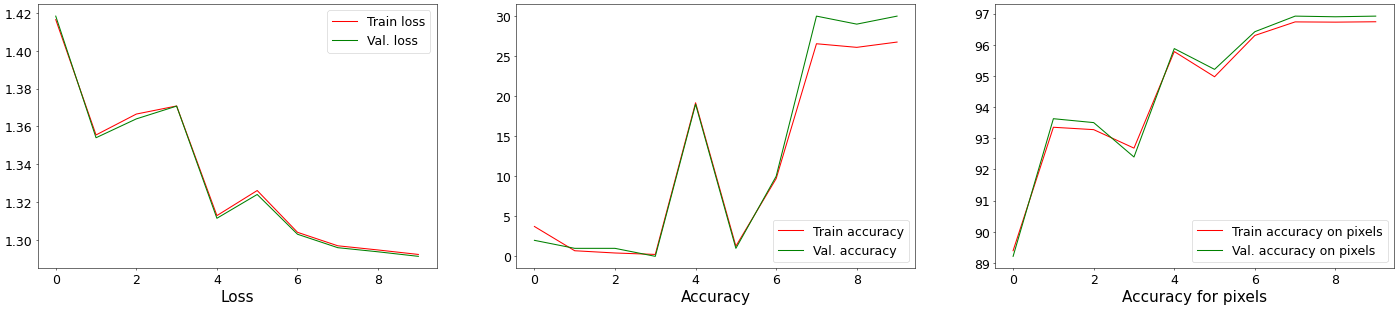

In [0]:
plot_metrics(LSTM_result_T1) # LSTM alone

### CNN


In [0]:
class CNN(nn.Module):

  def __init__(self, task_train, w, h):
    super(CNN, self).__init__()

    self.out_dim = np.array(np.array(task_train[0]['output']).shape)
    self.conv = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=5, padding=2)

  def forward(self, x):  
    x = x.unsqueeze(0)
    x = torch.nn.Upsample(size=(self.out_dim[0], self.out_dim[1]))(x)
    x = self.conv(x)
    return x

In [0]:
# Training
CNN_result_T1, CNN_predictions_T1, CNN_wrong_pred_T1 = evaluate_metrics(task_builder(10000, 100), CNN, 
                                                                            n_epoch = 10, verbose = True)


Epoch: [1/10]
Train loss is: 2.0037751794355922
Validation loss is: 2.4220959290862085
Train accuracy is: 0.01 %
Train accuracy for pixels is: 58.297916666666666 %
Validation accuracy is: 0.0 %
Validation accuracy for pixels is: 56.8125 %

Epoch: [2/10]
Train loss is: 2.0418975167553164
Validation loss is: 2.400039077401161
Train accuracy is: 0.02 %
Train accuracy for pixels is: 56.55833333333333 %
Validation accuracy is: 0.0 %
Validation accuracy for pixels is: 54.8125 %

Epoch: [3/10]
Train loss is: 1.8684832660250366
Validation loss is: 1.9455296143889427
Train accuracy is: 0.01 %
Train accuracy for pixels is: 54.63645833333333 %
Validation accuracy is: 0.0 %
Validation accuracy for pixels is: 54.229166666666664 %

Epoch: [4/10]
Train loss is: 1.8437074086218375
Validation loss is: 2.1397226589918135
Train accuracy is: 0.01 %
Train accuracy for pixels is: 57.045833333333334 %
Validation accuracy is: 0.0 %
Validation accuracy for pixels is: 56.104166666666664 %

Epoch: [5/10]
Train 

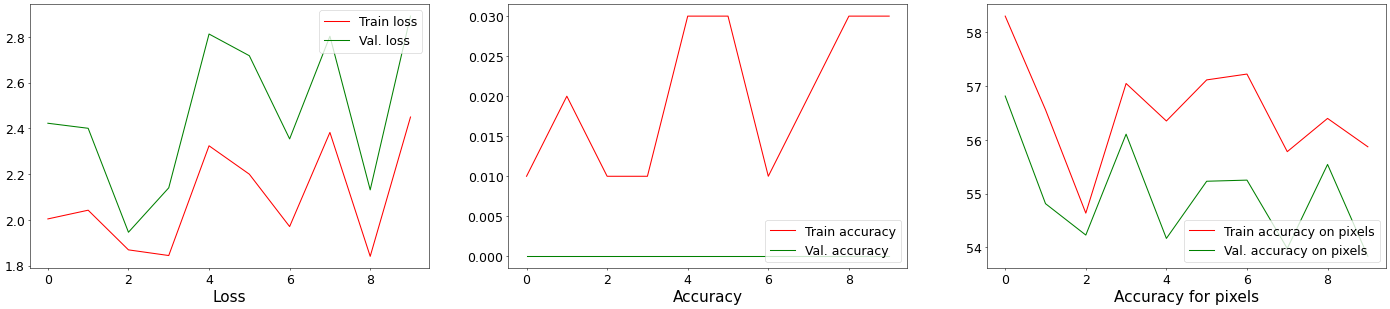

In [0]:
plot_metrics(CNN_result_T1)

## Task 4

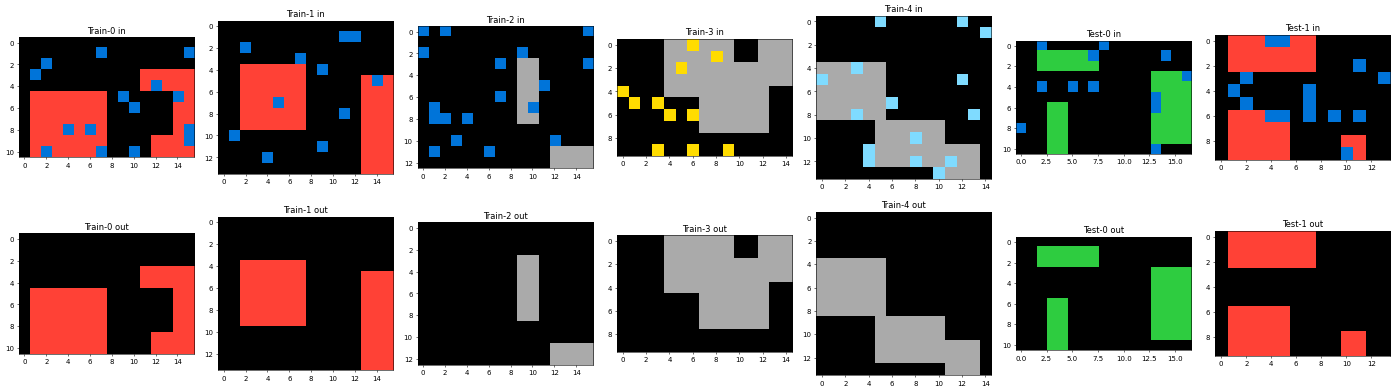

In [0]:
def task_builder(n_train=1000, n_test=250):
    task={'train':[], 'test':[]}
    for i in range(0,n_train):
        inp, out = gener_four()
        task['train'].append({'input':inp, 'output':out})
    for i in range(0,n_test):
        inp, out = gener_four()
        task['test'].append({'input':inp, 'output':out})
    return task

task=task_builder(5, 2)
plot_task(task)

### Fully Connected NN

In [0]:
class FullyConNN_T4(nn.Module):
  def __init__(self, task_train, sh1_big, sh2_big):
    super(FullyConNN_T4, self).__init__()

    self.largest_w = sh1_big
    self.largest_h = sh2_big
    self.linear = nn.Linear(self.largest_w*self.largest_h*10, self.largest_w*self.largest_h*10)

  def forward(self, x):  
    ch, input_w, input_h = x.shape[0], x.shape[1], x.shape[2]
    x = pad_crop(x, self.largest_w, self.largest_h, input_w, input_h, goal='pad') # Padding
    x = x.view(-1).unsqueeze(0) # Flatten
    x = self.linear(x) # Dense
    x = torch.reshape(x, (1, 10, self.largest_w, self.largest_h)) # Reshape
    x = pad_crop(x, input_w, input_h, self.largest_w, self.largest_h, goal='crop') # Cropping
    return x

In [212]:
fcNN_results_T4, fcNN_predictions_T4, fcNN_wrong_pred_T4 = evaluate_metrics(task_builder(1000, 50), FullyConNN_T4, n_epoch = 10, verbose = True)


Epoch: [1/10]
Train loss is: 1.7143103204905463
Validation loss is: 3.278173967599869
Train accuracy is: 0.6 %
Train accuracy for pixels is: 94.7558659900281 %
Validation accuracy is: 0.0 %
Validation accuracy for pixels is: 91.56733875459507 %

Epoch: [2/10]
Train loss is: 1.082933010999714
Validation loss is: 3.325766346901655
Train accuracy is: 1.8 %
Train accuracy for pixels is: 96.86962122305754 %
Validation accuracy is: 0.0 %
Validation accuracy for pixels is: 92.99320485685641 %

Epoch: [3/10]
Train loss is: 1.0317317193313007
Validation loss is: 3.4653861555457115
Train accuracy is: 2.7 %
Train accuracy for pixels is: 97.46593672615016 %
Validation accuracy is: 0.0 %
Validation accuracy for pixels is: 93.78411496045449 %

Epoch: [4/10]
Train loss is: 0.758667662370167
Validation loss is: 3.2765578305721283
Train accuracy is: 6.8 %
Train accuracy for pixels is: 98.17551886111512 %
Validation accuracy is: 0.0 %
Validation accuracy for pixels is: 94.67528127436783 %

Epoch: [5/10

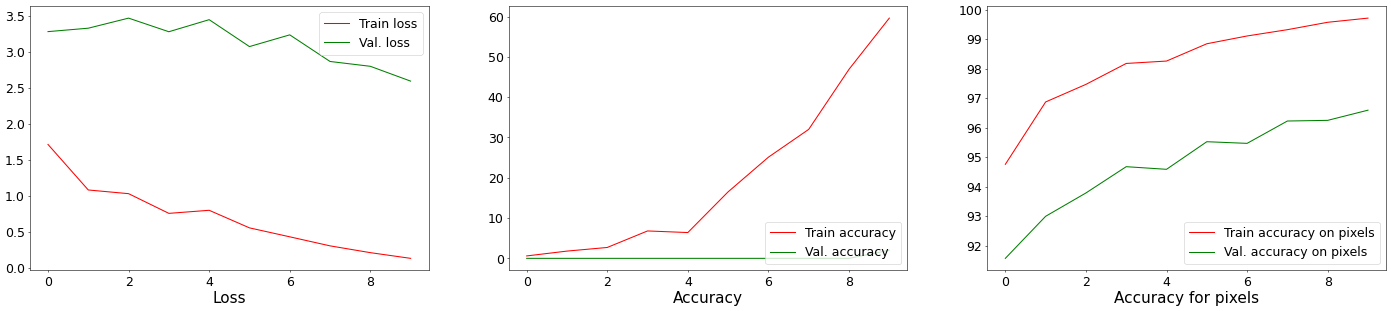

In [213]:
plot_metrics(fcNN_results_T4)

### LSTM

In [0]:
class LSTM_T4(nn.Module):
  def __init__(self, task_train, sh1_big, sh2_big):
    super(LSTM_T4, self).__init__() 

    self.largest_w = sh1_big
    self.largest_h = sh2_big
    self.LSTM = nn.LSTM(self.largest_w*self.largest_h, self.largest_w*self.largest_h, dropout=0, batch_first=True)
    #self.linear = nn.Linear(self.largest_w*self.largest_h, self.largest_w*self.largest_h)

  def forward(self, x):     

    ch, input_w, input_h = x.shape[0], x.shape[1], x.shape[2]
    x = pad_crop(x, self.largest_w, self.largest_h, input_w, input_h, goal='pad') # Padding
    x = x.view(ch, -1).unsqueeze(0)
    x, _ = self.LSTM(x)
    #x = self.linear(x)    
    x = torch.reshape(x, (1, 10, self.largest_w, self.largest_h)) 
    x = pad_crop(x, input_w, input_h, self.largest_w, self.largest_h, goal='crop') # Cropping
    
    return x

In [166]:
# Training
LSTM_results_T4, LSTM_predictions_T4, LSTM_wrong_pred_T4 = evaluate_metrics(task_builder(5000, 50), LSTM_T4, n_epoch = 10, verbose = True)


Epoch: [1/10]
Train loss is: 1.9323675471544266
Validation loss is: 1.9307781267166138
Train accuracy is: 0.0 %
Train accuracy for pixels is: 60.67013166008571 %
Validation accuracy is: 0.0 %
Validation accuracy for pixels is: 61.29032258064516 %

Epoch: [2/10]
Train loss is: 1.9342470394849778
Validation loss is: 1.933322787284851
Train accuracy is: 0.0 %
Train accuracy for pixels is: 61.63670201911508 %
Validation accuracy is: 0.0 %
Validation accuracy for pixels is: 62.30042359074617 %

Epoch: [3/10]
Train loss is: 1.9396085836648942
Validation loss is: 1.9389747285842895
Train accuracy is: 0.0 %
Train accuracy for pixels is: 61.239279688752745 %
Validation accuracy is: 0.0 %
Validation accuracy for pixels is: 61.73563592918432 %

Epoch: [4/10]
Train loss is: 1.9342460368394851
Validation loss is: 1.9337265753746034
Train accuracy is: 0.0 %
Train accuracy for pixels is: 61.946588847419484 %
Validation accuracy is: 0.0 %
Validation accuracy for pixels is: 62.40903660258499 %

Epoch:

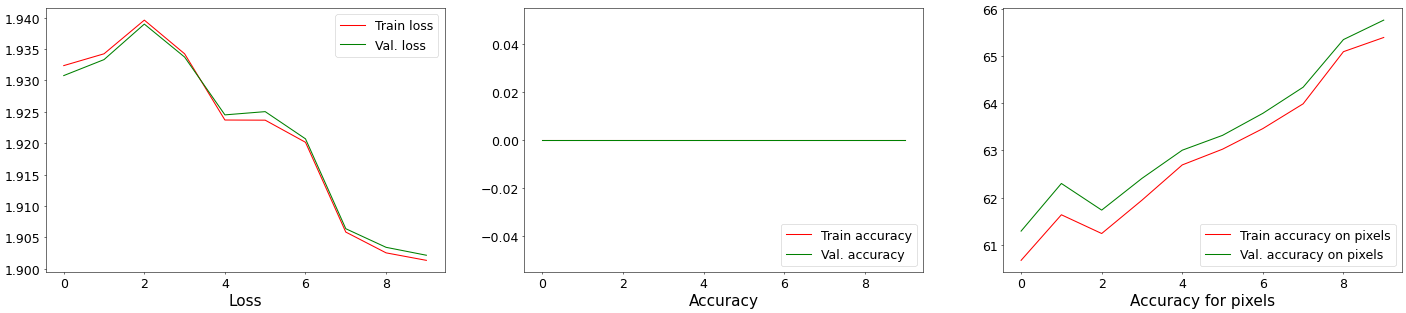

In [167]:
plot_metrics(LSTM_results_T4)

### CNN


In [0]:
# Basic CNN
class CNN_T4(nn.Module):
  def __init__(self, task_train, sh1_big, sh2_big):
    super(CNN_T4, self).__init__()

    self.largest_w = sh1_big
    self.largest_h = sh2_big
    self.conv = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=5, padding=2)

  def forward(self, x):  
    ch, input_w, input_h = x.shape[0], x.shape[1], x.shape[2]
    x = pad_crop(x, self.largest_w, self.largest_h, input_w, input_h, goal='pad')
    x = x.unsqueeze(0)
    x = self.conv(x)
    x = x = pad_crop(x, input_w, input_h, self.largest_w, self.largest_h, goal='crop')
    return x

In [0]:
# Training
CNN_result_T4, CNN_predictions_T4, CNN_wrong_pred_T4 = evaluate_metrics(task_builder(10000, 100), CNN_T4, 
                                                                            n_epoch = 10, verbose = True)


Epoch: [1/10]
Train loss is: 0.017865435776932243
Validation loss is: 0.017901566244940163
Train accuracy is: 74.14 %
Train accuracy for pixels is: 99.82379782185295 %
Validation accuracy is: 75.0 %
Validation accuracy for pixels is: 99.83706949828643 %

Epoch: [2/10]
Train loss is: 0.02412104081998902
Validation loss is: 0.022871617252991007
Train accuracy is: 72.57 %
Train accuracy for pixels is: 99.80484777627865 %
Validation accuracy is: 75.0 %
Validation accuracy for pixels is: 99.82583291196134 %

Epoch: [3/10]
Train loss is: 0.027492087609898692
Validation loss is: 0.026428124206954437
Train accuracy is: 70.18 %
Train accuracy for pixels is: 99.78534363580451 %
Validation accuracy is: 70.0 %
Validation accuracy for pixels is: 99.78650485982358 %

Epoch: [4/10]
Train loss is: 0.02472965428655294
Validation loss is: 0.021983684522164787
Train accuracy is: 72.41 %
Train accuracy for pixels is: 99.80595596607832 %
Validation accuracy is: 76.0 %
Validation accuracy for pixels is: 99

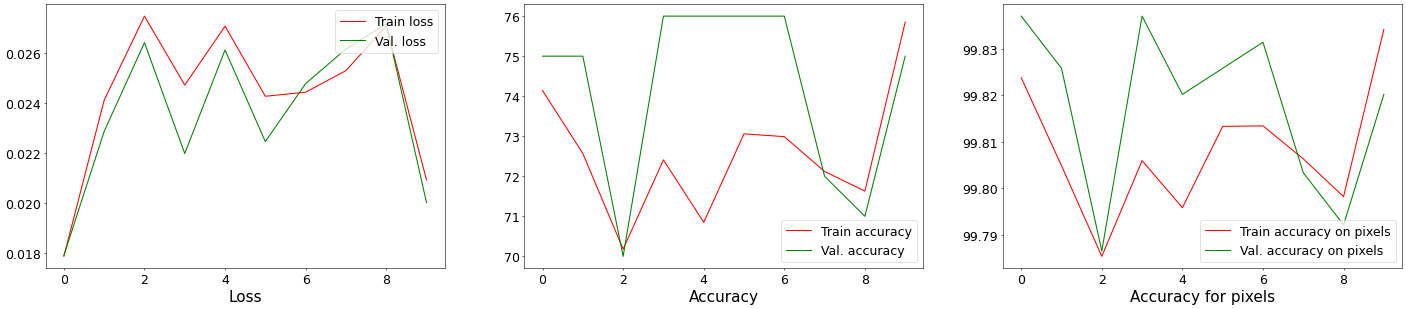

In [0]:
plot_metrics(CNN_result_T4)